In [7]:
import pandas as pd
import numpy as np
import re
import math
from collections import Counter
import itertools
import jieba

In [8]:

def preprocess_text(text):
    """
    Text preprocessing: word segmentation, cleaning, standardization
    """
    if pd.isna(text):
        return []
    
    # jieba
    text = str(text)
    # words = jieba.lcut(text)
    words=list(text)
    
    # remove non-Chinese characters
    chinese_pattern = re.compile(r'[^\u4e00-\u9fa5]')
    words = [word for word in words if not chinese_pattern.match(word)]
    
    # remove stop words
    stop_words = {'的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '上', '也', '很', '到', '说', '要', '去', '你', '会'}
    words = [word for word in words if word not in stop_words]
    
    return words

def calculate_mutual_info_pairwise(docs):
    """
    Calculate mutual information between any two articles
    """
    n_docs = len(docs)
    mutual_info_matrix = np.zeros((n_docs, n_docs))
    
    # Build global vocabulary
    all_words = set()
    for doc in docs:
        all_words.update(doc)
    vocab = list(all_words)
    vocab_size = len(vocab)
    
    print(f"Vocabulary size: {vocab_size}")
    print(f"Number of documents: {n_docs}")
    
    # Calculate word frequency distribution for each document
    doc_word_freq = []
    for doc in docs:
        word_count = Counter(doc)
        total_words = len(doc)
        if total_words == 0:
            freq_dist = {word: 0 for word in vocab}
        else:
            freq_dist = {word: word_count.get(word, 0) / total_words for word in vocab}
        doc_word_freq.append(freq_dist)
    
    # Calculate global word frequency distribution
    all_doc_words = [word for doc in docs for word in doc]
    global_word_count = Counter(all_doc_words)
    total_global_words = len(all_doc_words)
    global_freq = {word: global_word_count.get(word, 0) / total_global_words for word in vocab}
    
    # Calculate mutual information between any two articles
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Only calculate upper triangle to avoid duplication
            mi = calculate_pairwise_mi(doc_word_freq[i], doc_word_freq[j], global_freq, vocab)
            mutual_info_matrix[i, j] = mi
            mutual_info_matrix[j, i] = mi  # Symmetric matrix
    
    return mutual_info_matrix

def calculate_pairwise_mi(p_dist, q_dist, global_freq, vocab):
    """
    Calculate mutual information between two documents
    Based on KL divergence: MI(P,Q) = 0.5 * [D_KL(P||M) + D_KL(Q||M)]
    where M = 0.5*(P + Q)
    """
    epsilon = 1e-10  # To avoid log(0)
    
    # Calculate average distribution M
    m_dist = {}
    for word in vocab:
        m_dist[word] = 0.5 * (p_dist.get(word, epsilon) + q_dist.get(word, epsilon))
    
    # Calculate KL divergence
    kl_pm = 0
    kl_qm = 0
    
    for word in vocab:
        p_val = p_dist.get(word, epsilon)
        q_val = q_dist.get(word, epsilon)
        m_val = m_dist[word]
        
        if p_val > epsilon and m_val > epsilon:
            kl_pm += p_val * math.log(p_val / m_val)
        if q_val > epsilon and m_val > epsilon:
            kl_qm += q_val * math.log(q_val / m_val)
    
    # Calculate mutual information
    mutual_info = 0.5 * (kl_pm + kl_qm)
    
    return mutual_info

def calculate_jensen_shannon_divergence(p_dist, q_dist, vocab):
    """
    Calculate Jensen-Shannon divergence (another similarity measure)
    JS(P||Q) = 0.5 * KL(P||M) + 0.5 * KL(Q||M), where M = 0.5*(P+Q)
    """
    epsilon = 1e-10
    
    # Calculate average distribution M
    m_dist = {}
    for word in vocab:
        m_dist[word] = 0.5 * (p_dist.get(word, epsilon) + q_dist.get(word, epsilon))
    
    # Calculate KL divergence
    kl_pm = 0
    kl_qm = 0
    
    for word in vocab:
        p_val = p_dist.get(word, epsilon)
        q_val = q_dist.get(word, epsilon)
        m_val = m_dist[word]
        
        if p_val > epsilon and m_val > epsilon:
            kl_pm += p_val * math.log(p_val / m_val)
        if q_val > epsilon and m_val > epsilon:
            kl_qm += q_val * math.log(q_val / m_val)
    
    js_divergence = 0.5 * kl_pm + 0.5 * kl_qm
    return js_divergence

def analyze_mutual_info_results(mi_matrix, titles):
    """
    Analyze mutual information results
    """
    n_docs = len(titles)
    
    # Find document pairs with highest mutual information
    highest_mi_pairs = []
    for i in range(n_docs):
        for j in range(i + 1, n_docs):
            highest_mi_pairs.append((i, j, mi_matrix[i, j]))
    
    # Sort by mutual information value
    highest_mi_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\n=== Mutual Information Analysis Results ===")
    print(f"Number of documents: {n_docs}")
    print(f"Number of document pairs: {len(highest_mi_pairs)}")
    print(f"Mutual information range: [{np.min(mi_matrix):.6f}, {np.max(mi_matrix):.6f}]")
    print(f"Average mutual information: {np.mean(mi_matrix):.6f}")
    print(f"Median mutual information: {np.median(mi_matrix):.6f}")
    
    # Display top 10 document pairs with highest mutual information
    print("\nTop 10 document pairs with highest mutual information:")
    for idx, (i, j, mi) in enumerate(highest_mi_pairs[:10]):
        print(f"{idx+1}. Document {i}↔Document {j}: {mi:.6f}")
        print(f"   Title {i}: {titles[i][:30]}...")
        print(f"   Title {j}: {titles[j][:30]}...")
        print()
    
    return highest_mi_pairs

def create_mutual_info_visualization(mi_matrix, titles, basedata):
    """
    Create visualization for mutual information matrix
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'WenQuanYi Zen Hei', 'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'Document Mutual Information Analysis--{basedata}', fontsize=16)
    
    # 1. Heatmap
    sns.heatmap(mi_matrix, ax=ax1, cmap='YlGnBu',
                xticklabels=False, yticklabels=False,
                cbar_kws={'label': 'Mutual Information'})
    ax1.set_title('Mutual Information Matrix Heatmap')
    ax1.set_xlabel('Document Index')
    ax1.set_ylabel('Document Index')
    
    # 2. Mutual Information Value Distribution Histogram
    # Only take the upper triangle to avoid double counting
    upper_triangle = mi_matrix[np.triu_indices_from(mi_matrix, k=1)]
    ax2.hist(upper_triangle, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Mutual Information Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Mutual Information Values Between Documents')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    #让 text 在 ax2 左上角显示
    stats_text = f"""Statistics:
Number of Documents: {len(titles)}
Number of Document Pairs: {len(upper_triangle)}
Minimum: {np.min(upper_triangle):.6f}
Maximum: {np.max(upper_triangle):.6f}
Mean: {np.mean(upper_triangle):.6f}
Median: {np.median(upper_triangle):.6f}"""
    
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'./picture/{basedata}_document_mutual_info_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def main(basedata):
    print(f"Starting document mutual information analysis for dataset: {basedata}.csv")
    # read data
    try:
        df = pd.read_csv(f'./data/{basedata}.csv', encoding='utf-8-sig')
        print(f"Data shape: {df.shape}")
        print(f"Column names: {df.columns.tolist()}")
    except Exception as e:
        print(f"Failed to read file: {e}")
        return
    
    # Check data columns
    if len(df.columns) < 2:
        print("Data file must contain at least two columns: title and content")
        return
    
    title_col = df.columns[0]
    content_col = df.columns[1]
    
    print(f"Using columns: '{title_col}' as title, '{content_col}' as content")
    
    # Preprocess text
    titles = df[title_col].tolist()
    contents = df[content_col].tolist()
    
    # Preprocess all document contents
    processed_docs = []
    valid_indices = []
    
    for i, content in enumerate(contents):
        processed = preprocess_text(content)
        if len(processed) > 10:  # Only keep documents with sufficient content
            processed_docs.append(processed)
            valid_indices.append(i)
    
    print(f"Number of valid documents: {len(processed_docs)}")
    
    if len(processed_docs) < 2:
        print("Insufficient number of valid documents to calculate mutual information")
        return
    
    # Calculate mutual information matrix
    mi_matrix = calculate_mutual_info_pairwise(processed_docs)
    
    # Analyze results
    valid_titles = [titles[i] for i in valid_indices]
    highest_mi_pairs = analyze_mutual_info_results(mi_matrix, valid_titles)
    
    # Create visualization
    create_mutual_info_visualization(mi_matrix, valid_titles, basedata)
    
    # Save results
    results_df = pd.DataFrame({
        'doc_index_i': [i for i, j, _ in highest_mi_pairs],
        'doc_index_j': [j for i, j, _ in highest_mi_pairs],
        'mutual_info': [mi for _, _, mi in highest_mi_pairs],
        'title_i': [valid_titles[i] for i, j, _ in highest_mi_pairs],
        'title_j': [valid_titles[j] for i, j, _ in highest_mi_pairs]
    })
    
    results_df.to_csv(f'./data/{basedata}_document_mutual_info_results.csv', index=False, encoding='utf-8-sig')
    print(f"\nResults saved to: ./data/{basedata}_document_mutual_info_results.csv")

Starting document mutual information analysis for dataset: xinlangnews.csv
Data shape: (975, 2)
Column names: ['文本标题', '文本内容']
Using columns: '文本标题' as title, '文本内容' as content
Number of valid documents: 968
Vocabulary size: 3424
Number of documents: 968

=== Mutual Information Analysis Results ===
Number of documents: 968
Number of document pairs: 468028
Mutual information range: [0.000000, 0.693147]
Average mutual information: 0.453873
Median mutual information: 0.455980

Top 10 document pairs with highest mutual information:
1. Document 140↔Document 209: 0.693147
   Title 140: 影视院线板块震荡走高，博纳影业涨停...
   Title 209: X被欧盟罚款1.4亿美元 美国官员及马斯克纷纷表示强烈反对！...

2. Document 215↔Document 269: 0.693147
   Title 215: 光伏设备板块短线拉升，协鑫集成直线涨停...
   Title 269: 宁高宁：企业家精神就是创新，没有创新我们什么都不是...

3. Document 269↔Document 280: 0.693147
   Title 269: 宁高宁：企业家精神就是创新，没有创新我们什么都不是...
   Title 280: 海南自贸区概念走强，海南发展涨停...

4. Document 280↔Document 875: 0.693147
   Title 280: 海南自贸区概念走强，海南发展涨停...
   Title 875: 荣耀工程师谈豆包手机：AI时代新的交互

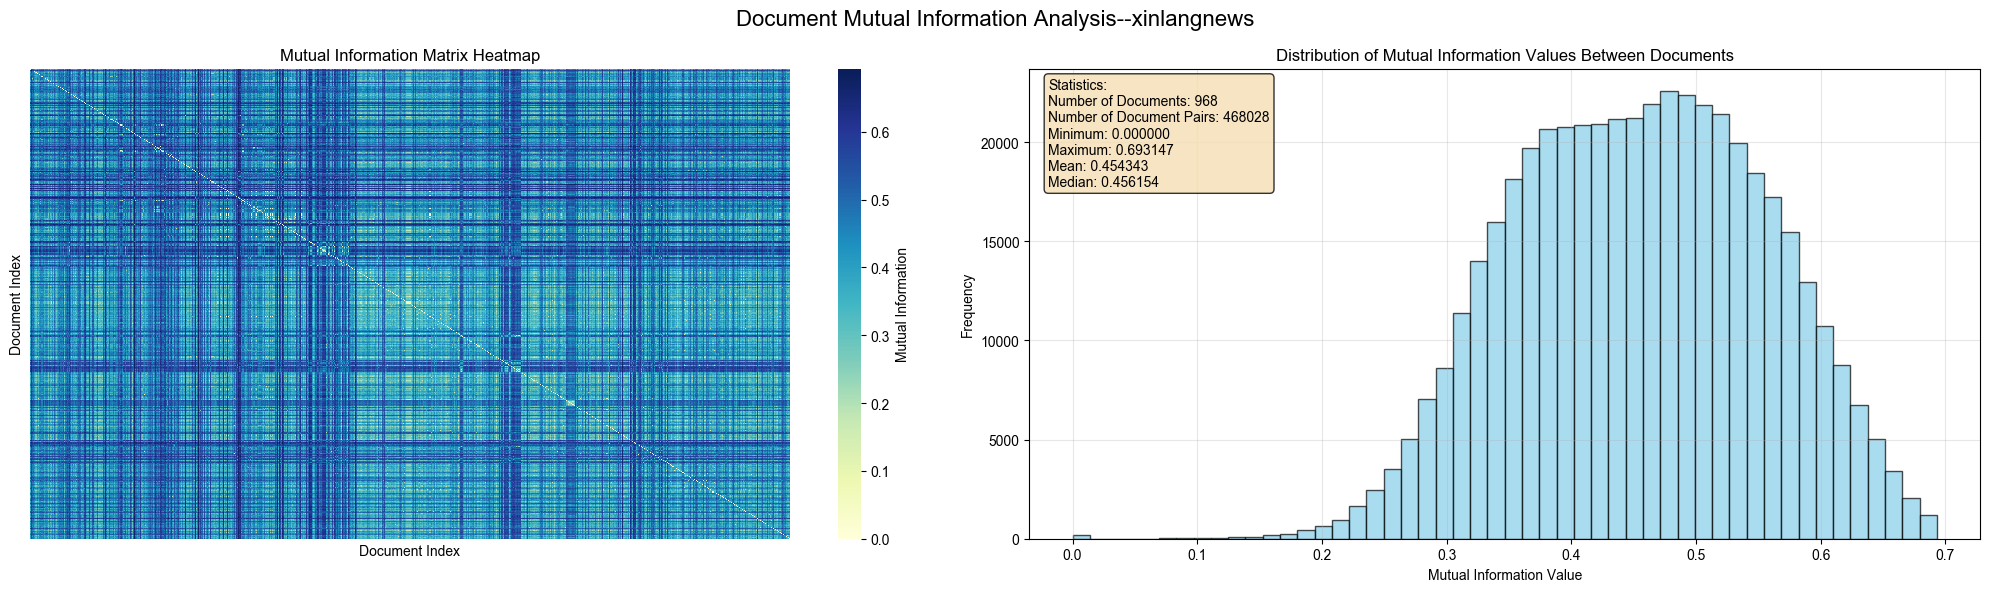


Results saved to: ./data/xinlangnews_document_mutual_info_results.csv
Starting document mutual information analysis for dataset: chinanews.csv
Data shape: (965, 2)
Column names: ['文本标题', '文本内容']
Using columns: '文本标题' as title, '文本内容' as content
Number of valid documents: 964
Vocabulary size: 3869
Number of documents: 964

=== Mutual Information Analysis Results ===
Number of documents: 964
Number of document pairs: 464166
Mutual information range: [0.000000, 0.693147]
Average mutual information: 0.451349
Median mutual information: 0.462667

Top 10 document pairs with highest mutual information:
1. Document 63↔Document 910: 0.693147
   Title 63: 广西南宁紫风铃花盛开 冬日“春景”引游人...
   Title 910: 第十五届广州国际干细胞与再生医学论坛举行...

2. Document 205↔Document 810: 0.693147
   Title 205: 青少年也会得痛风？这些诱因要警惕...
   Title 810: 谋篇布局“十五五”·热点问答|如何稳步推进基本公共服务均等化...

3. Document 735↔Document 810: 0.693147
   Title 735: 成都混团世界杯四强出炉 中国队九战九胜头名晋级...
   Title 810: 谋篇布局“十五五”·热点问答|如何稳步推进基本公共服务均等化...

4. Document 750↔Document 810: 0.

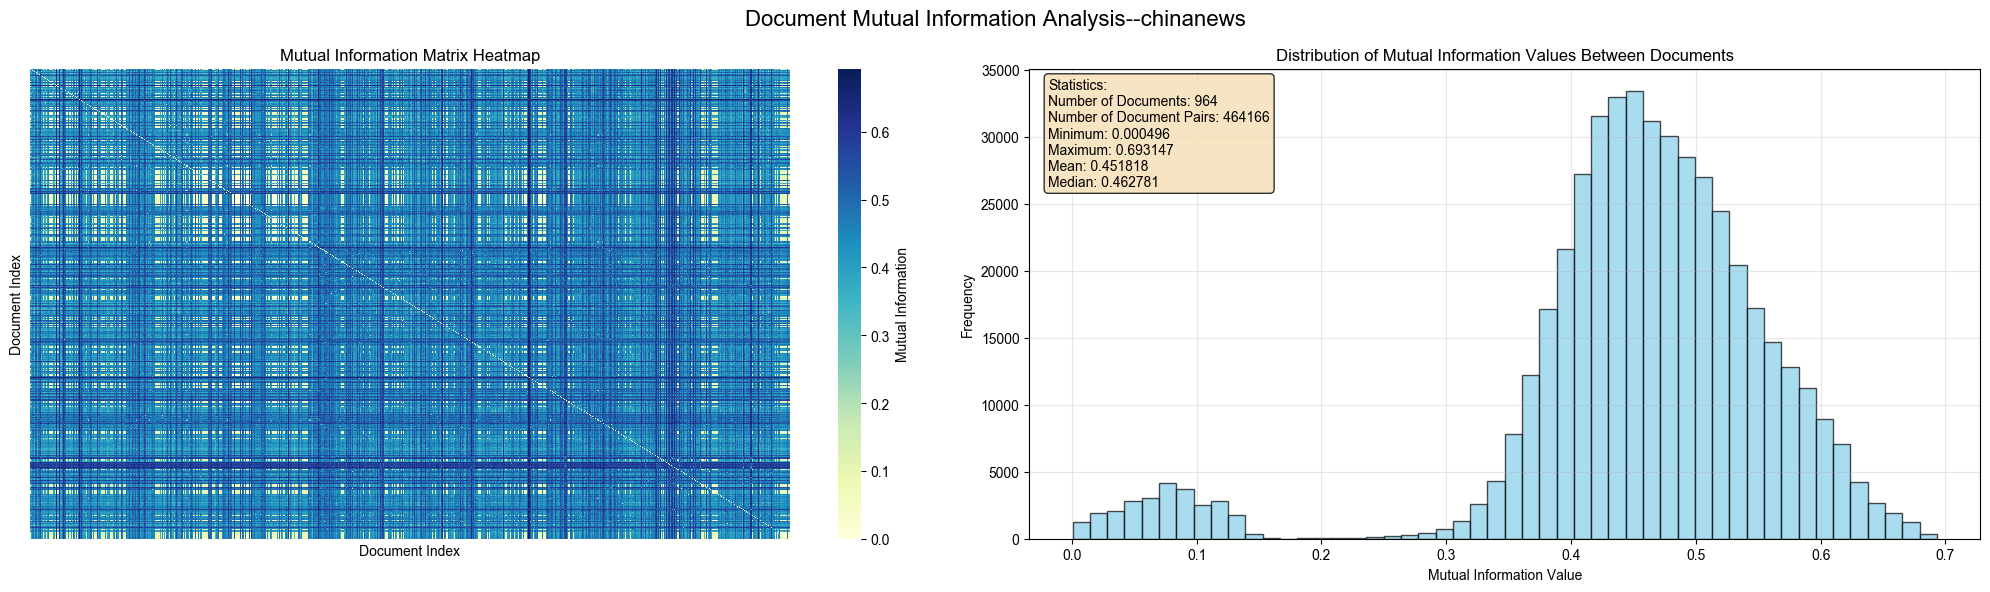


Results saved to: ./data/chinanews_document_mutual_info_results.csv


In [9]:
#xinlangnews
if __name__ == "__main__":
    basedata = 'xinlangnews' 
    main(basedata)
    basedata = 'chinanews' 
    main(basedata)